# Causal Impact Analysis
> Google’s python package `CausalImpact` for time series intervention causal inference with Bayesian Structural Time Series Model (BSTS)

### Incrementality experiments are the gold standard, Causal Impact should be used when those are not an option

![alt text](https://github.com/tottenjordan/vertex-forecas-repo/blob/main/imgs/causal-impact-overview.png)

In [1]:
GCP_PROJECTS = !gcloud config get-value project
PROJECT_ID = GCP_PROJECTS[0]
PROJECT_NUM = !gcloud projects list --filter="$PROJECT_ID" --format="value(PROJECT_NUMBER)"
PROJECT_NUM = PROJECT_NUM[0]
LOCATION = 'us-central1'
REGION = "us-central1"

# VERTEX_SA = '934903580331-compute@developer.gserviceaccount.com'
VERTEX_SA = 'jt-vertex-sa@hybrid-vertex.iam.gserviceaccount.com'

print(f"PROJECT_ID: {PROJECT_ID}")
print(f"PROJECT_NUM: {PROJECT_NUM}")
print(f"LOCATION: {LOCATION}")
print(f"REGION: {REGION}")
print(f"VERTEX_SA: {VERTEX_SA}")

PROJECT_ID: hybrid-vertex
PROJECT_NUM: 934903580331
LOCATION: us-central1
REGION: us-central1
VERTEX_SA: jt-vertex-sa@hybrid-vertex.iam.gserviceaccount.com


In [18]:
from google.cloud import bigquery

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

import seaborn as sns
sns.set(rc={'figure.figsize':(18,6)})

from google.cloud import aiplatform as vertex_ai

# Causal impact
from causalimpact import CausalImpact

In [3]:
bq_client = bigquery.Client(project=PROJECT_ID)

vertex_ai.init(
    project=PROJECT_ID, 
    location=REGION,
    # credentials=credentials
)

## Set Variables

In [4]:
EXPERIMENT = 'causal_impact_v1'
SERIES = 'causal_v1'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = EXPERIMENT

BQ_SOURCE1 = 'bigquery-public-data.new_york.citibike_trips'
BQ_SOURCE2 = 'bigquery-public-data.new_york.citibike_stations'
viz_limit = 9

In [8]:
# CUSTOMIZE
forecast_granularity = 'DAY'
forecast_horizon = 7
forecast_test_length = 150
forecast_val_length = 31

CONTROL_GROUP='control_group'

INTERVENTION_DATE='2016-05-04'

# CUSTOMIZE
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'
COVARIATE_COLUMNS = ['avg_tripduration', 'pct_subscriber', 'ratio_gender', 'capacity'] # could be empty

# Only view trips with this key word in start station
station="Lafayette"

# for demo purposes, inflate response variable 
INFLATED_TARGET='num_trips_jt'

In [25]:
TREATMENT_DATE='2016-05-04'

## Review time series data

In [281]:
query = f"""
    SELECT 
        {SERIES_COLUMN}, 
        {TIME_COLUMN}, 
        {TARGET_COLUMN},
        {INFLATED_TARGET},
        splits,
        {CONTROL_GROUP},
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq_client.query(query).to_dataframe()

In [282]:
rawSeries

,start_station_name,starttime,num_trips,num_trips_jt,splits,control_group,avg_tripduration,pct_subscriber,ratio_gender,capacity
0,Clermont Ave & Lafayette Ave,2013-12-21,19,19,TRAIN,0,685.105263,0.947368,3.750000,51
1,Clermont Ave & Lafayette Ave,2013-12-22,12,12,TRAIN,0,652.750000,0.916667,1.400000,51
2,Clermont Ave & Lafayette Ave,2013-12-23,4,4,TRAIN,0,885.750000,1.000000,3.000000,51
3,Clermont Ave & Lafayette Ave,2013-12-24,7,7,TRAIN,0,433.714286,1.000000,2.500000,51
4,Clermont Ave & Lafayette Ave,2013-12-25,2,2,TRAIN,0,774.000000,1.000000,0.000000,51
...,...,...,...,...,...,...,...,...,...,...
7287,Marcy Ave & Lafayette Ave,2016-09-26,9,154,TEST,1,1119.666667,1.000000,8.000000,23
7288,Marcy Ave & Lafayette Ave,2016-09-27,14,159,TEST,1,1127.928571,1.000000,0.750000,23
7289,Marcy Ave & Lafayette Ave,2016-09-28,11,156,TEST,1,1089.272727,1.000000,2.666667,23
7290,Marcy Ave & Lafayette Ave,2016-09-29,9,154,TEST,1,1229.333333,0.777778,1.250000,23


### View time series IDs (stations)

In [11]:
query = f"""
    SELECT 
      start_station_name, 
      count(*) as Count, 
      100*count(*) / (sum(count(*)) OVER()) as Percentage
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    GROUP BY start_station_name
    ORDER BY Count DESC;
"""
bq_client.query(query = query).to_dataframe()

,start_station_name,Count,Percentage
0,Lafayette Ave & Fort Greene Pl,1008,13.823368
1,Clermont Ave & Lafayette Ave,1006,13.795941
2,Cumberland St & Lafayette Ave,1005,13.782227
3,Lafayette Ave & Classon Ave,999,13.699945
4,Lafayette Ave & St James Pl,998,13.686231
5,Lafayette St & E 8 St,937,12.849698
6,Lafayette St & Jersey St,935,12.822271
7,Marcy Ave & Lafayette Ave,385,5.279759
8,Lafayette St & Jersey St N,19,0.260560


### Aggregated time series

In [53]:
query = f"""
    SELECT 
        {SERIES_COLUMN}, 
        sum({TARGET_COLUMN}) as {TARGET_COLUMN},
        sum({INFLATED_TARGET}) as {INFLATED_TARGET},
        min({TIME_COLUMN}) as FromDate,
        max({TIME_COLUMN}) as ToDate
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {TARGET_COLUMN} DESC;
"""
overview = bq_client.query(query).to_dataframe()
overview.head(viz_limit)

,start_station_name,num_trips,num_trips_jt,FromDate,ToDate
0,Lafayette St & E 8 St,231417,235152,2013-12-21,2016-08-22
1,Lafayette St & Jersey St,142686,149221,2013-12-21,2016-09-30
2,Lafayette Ave & Fort Greene Pl,24189,36454,2013-12-21,2016-09-30
3,Cumberland St & Lafayette Ave,23698,35528,2013-12-21,2016-09-27
4,Lafayette Ave & St James Pl,17430,29695,2013-12-21,2016-09-30
5,Clermont Ave & Lafayette Ave,17397,29662,2013-12-21,2016-09-30
6,Lafayette Ave & Classon Ave,17010,29275,2013-12-21,2016-09-30
7,Lafayette St & Jersey St N,4249,5674,2016-07-01,2016-07-19
8,Marcy Ave & Lafayette Ave,2433,14698,2015-08-25,2016-09-30


### Train-test splits

In [16]:
query = f"""
    SELECT 
        MIN({TIME_COLUMN}) as start_date,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {forecast_test_length+forecast_val_length}-1 DAY) as val_start,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {forecast_test_length}-1 DAY) as test_start,
        MAX({TIME_COLUMN}) as end_date,
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`  
"""
keyDates = bq_client.query(query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date
0,2013-12-21,2016-04-03,2016-05-04,2016-09-30


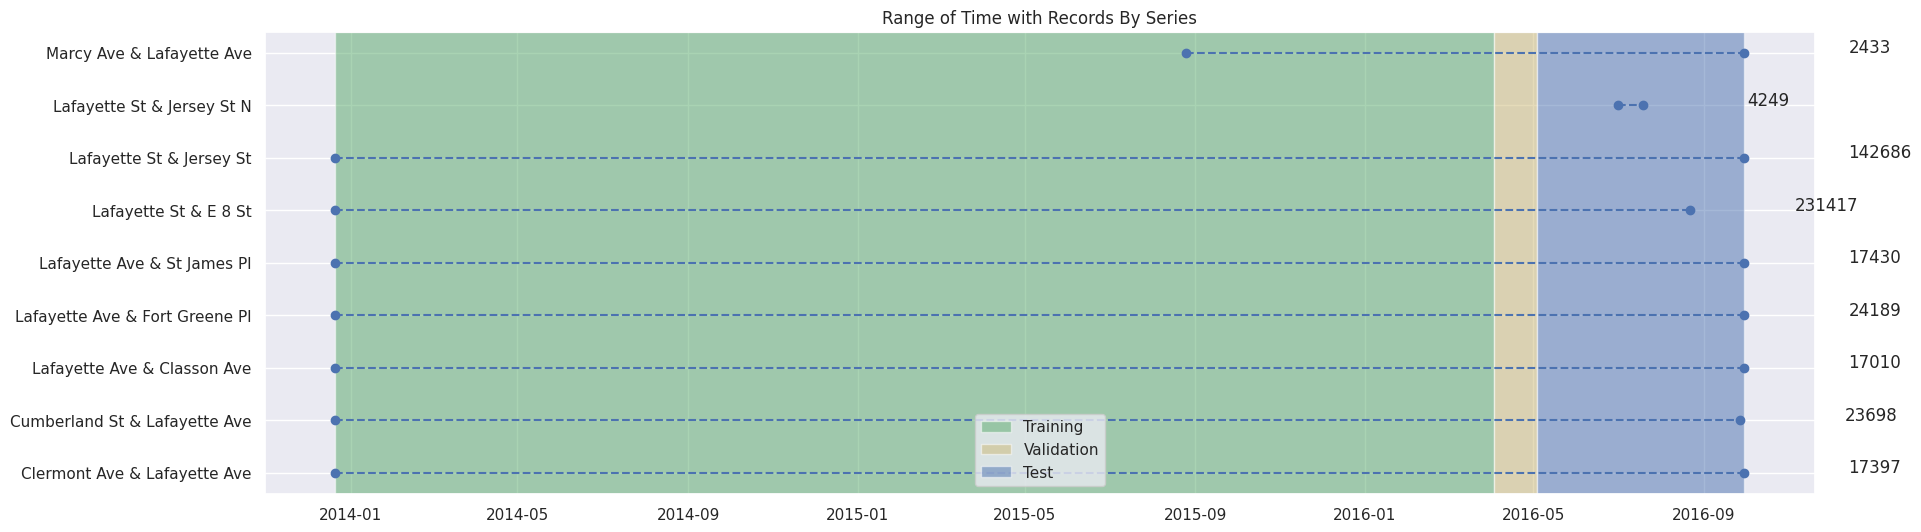

In [19]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview[TARGET_COLUMN][i]))
    plt.title('Range of Time with Records By Series')
plt.axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.5, label = 'Training')
plt.axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.5, label = 'Validation')
plt.axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.5, label = 'Test')
plt.legend(loc = 'lower center')
plt.show()

In [20]:
query = f"""
    SELECT 
        {SERIES_COLUMN},
        COUNTIF(splits='TRAIN') as TRAIN,
        COUNTIF(splits='VALIDATE') as VALIDATE,
        COUNTIF(splits='TEST') as TEST,
        COUNTIF({CONTROL_GROUP}=0) as pre_period,
        COUNTIF({CONTROL_GROUP}=1) as post_period,
        sum({TARGET_COLUMN}) as {TARGET_COLUMN},
        sum({INFLATED_TARGET}) as {INFLATED_TARGET}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
splitCounts = bq_client.query(query).to_dataframe()
splitCounts.head(viz_limit)

,start_station_name,TRAIN,VALIDATE,TEST,pre_period,post_period,num_trips,num_trips_jt
0,Clermont Ave & Lafayette Ave,825,31,150,856,150,17397,29662
1,Cumberland St & Lafayette Ave,827,31,147,858,147,23698,35528
2,Lafayette Ave & Classon Ave,818,31,150,849,150,17010,29275
3,Lafayette Ave & Fort Greene Pl,827,31,150,858,150,24189,36454
4,Lafayette Ave & St James Pl,817,31,150,848,150,17430,29695
5,Lafayette St & E 8 St,830,31,76,861,76,231417,235152
6,Lafayette St & Jersey St,813,31,91,844,91,142686,149221
7,Lafayette St & Jersey St N,0,0,19,0,19,4249,5674
8,Marcy Ave & Lafayette Ave,205,30,150,235,150,2433,14698


In [21]:
query = f"""
SELECT splits, count(*) as Count, 100*count(*) / (sum(count(*)) OVER()) as Percentage
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
GROUP BY splits
"""
bq_client.query(query = query).to_dataframe()

,splits,Count,Percentage
0,VALIDATE,247,3.387274
1,TRAIN,5962,81.760834
2,TEST,1083,14.851892


### plot single time series

#### Inspect the target time series

In [283]:
TARGET_NYC_STATION='Lafayette St & Jersey St'

rawSeries_nyc_target = rawSeries.loc[rawSeries['start_station_name'] == TARGET_NYC_STATION]
rawSeries_nyc_target

,start_station_name,starttime,num_trips,num_trips_jt,splits,control_group,avg_tripduration,pct_subscriber,ratio_gender,capacity
5953,Lafayette St & Jersey St,2013-12-21,50,50,TRAIN,0,653.560000,0.960000,2.571429,60
5954,Lafayette St & Jersey St,2013-12-22,40,40,TRAIN,0,530.000000,0.975000,2.636364,60
5955,Lafayette St & Jersey St,2013-12-23,16,16,TRAIN,0,649.062500,0.875000,4.333333,60
5956,Lafayette St & Jersey St,2013-12-24,23,23,TRAIN,0,818.000000,0.913043,2.285714,60
5957,Lafayette St & Jersey St,2013-12-25,2,2,TRAIN,0,236.000000,1.000000,0.000000,60
...,...,...,...,...,...,...,...,...,...,...
6883,Lafayette St & Jersey St,2016-09-26,232,377,TEST,1,735.474138,0.922414,2.362319,60
6884,Lafayette St & Jersey St,2016-09-27,238,383,TEST,1,760.726891,0.924370,1.975000,60
6885,Lafayette St & Jersey St,2016-09-28,231,376,TEST,1,637.714286,0.948052,2.553846,60
6886,Lafayette St & Jersey St,2016-09-29,225,370,TEST,1,646.822222,0.955556,2.750000,60


In [284]:
TREATMENT_DATE_obj = datetime.strptime(TREATMENT_DATE, '%Y-%m-%d').date()

rawSeries_nyc_target.reset_index(inplace=True)

rawSeries_nyc_target.loc[rawSeries_nyc_target['starttime'] == TREATMENT_DATE_obj]

,index,start_station_name,starttime,num_trips,num_trips_jt,splits,control_group,avg_tripduration,pct_subscriber,ratio_gender,capacity
844,6797,Lafayette St & Jersey St,2016-05-04,172,187,TEST,1,675.273256,0.930233,3.095238,60


In [285]:
rawSeries_nyc_target.set_index(TIME_COLUMN, inplace=True, drop=False)

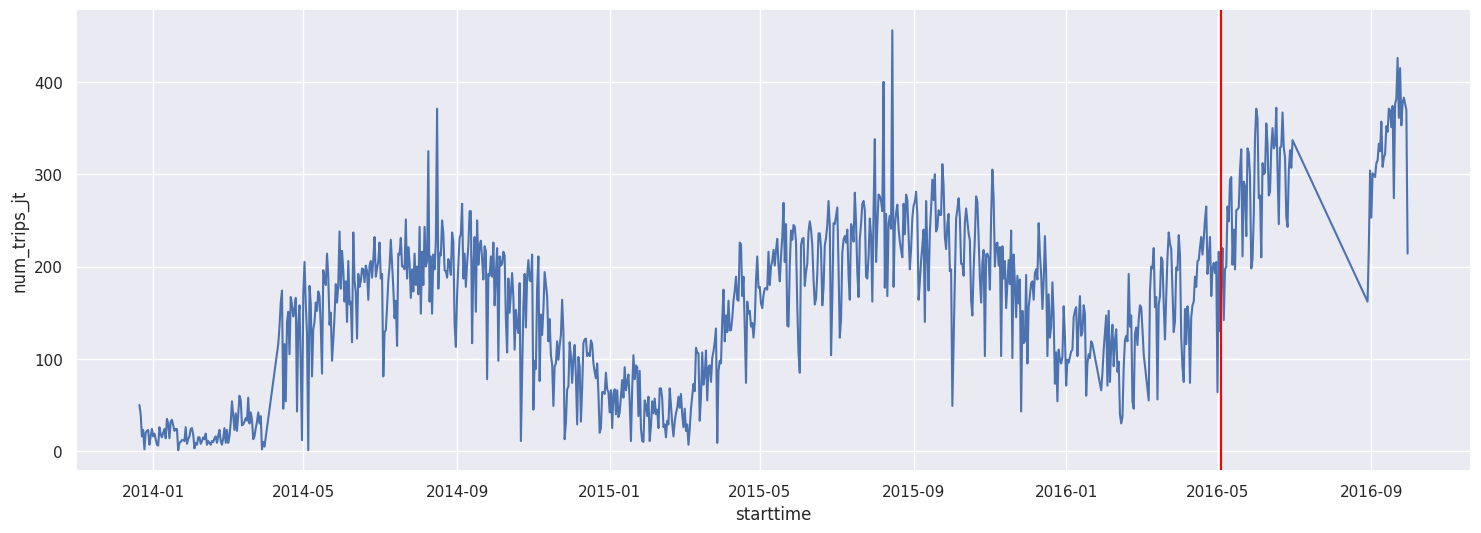

In [286]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(18,6)})
# sns.lineplot(x=rawSeries_nyc_target.index, y=rawSeries_nyc_target[TARGET_COLUMN])
sns.lineplot(x=rawSeries_nyc_target.index, y=rawSeries_nyc_target[INFLATED_TARGET])
plt.axvline(x= rawSeries_nyc_target.index[844], color='red');

#### Gather correlated/similar time series that are NOT impacted by the intervention

In [287]:
NYC_STATION_COV_1='Lafayette Ave & St James Pl'
NYC_STATION_COV_2='Cumberland St & Lafayette Ave'
NYC_STATION_COV_3='Lafayette Ave & Fort Greene Pl'
NYC_STATION_COV_4='Lafayette St & E 8 St'

rawSeries_nyc_cov_1 = rawSeries.loc[rawSeries['start_station_name'] == NYC_STATION_COV_1].reset_index() #inplace=True)
rawSeries_nyc_cov_2 = rawSeries.loc[rawSeries['start_station_name'] == NYC_STATION_COV_2].reset_index() #inplace=True)
rawSeries_nyc_cov_3 = rawSeries.loc[rawSeries['start_station_name'] == NYC_STATION_COV_3].reset_index() #inplace=True)
rawSeries_nyc_cov_4 = rawSeries.loc[rawSeries['start_station_name'] == NYC_STATION_COV_4].reset_index() #inplace=True)

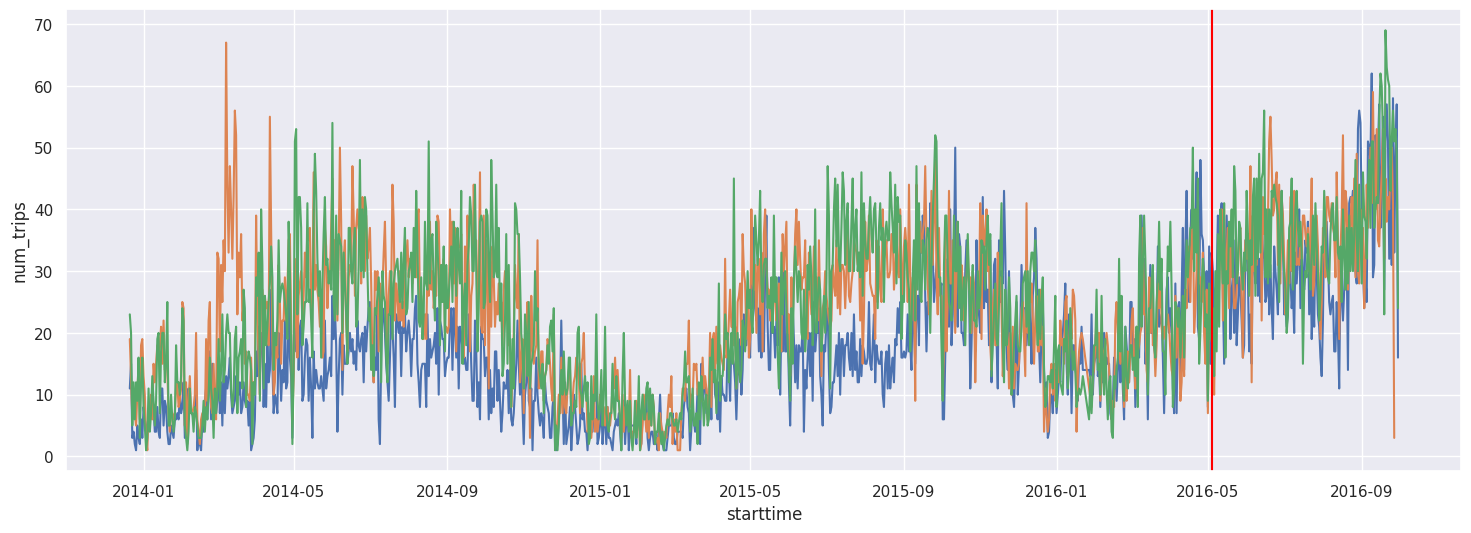

In [289]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(18,6)})
sns.lineplot(x=rawSeries_nyc_cov_1.starttime, y=rawSeries_nyc_cov_1[TARGET_COLUMN])
sns.lineplot(x=rawSeries_nyc_cov_2.starttime, y=rawSeries_nyc_cov_2[TARGET_COLUMN])
sns.lineplot(x=rawSeries_nyc_cov_3.starttime, y=rawSeries_nyc_cov_3[TARGET_COLUMN])
# sns.lineplot(x=rawSeries_nyc_cov_4.starttime, y=rawSeries_nyc_cov_4[TARGET_COLUMN])
# sns.lineplot(x=rawSeries_nyc_target.index, y=rawSeries_nyc_target[INFLATED_TARGET])
plt.axvline(x= rawSeries_nyc_target.index[844], color='red');

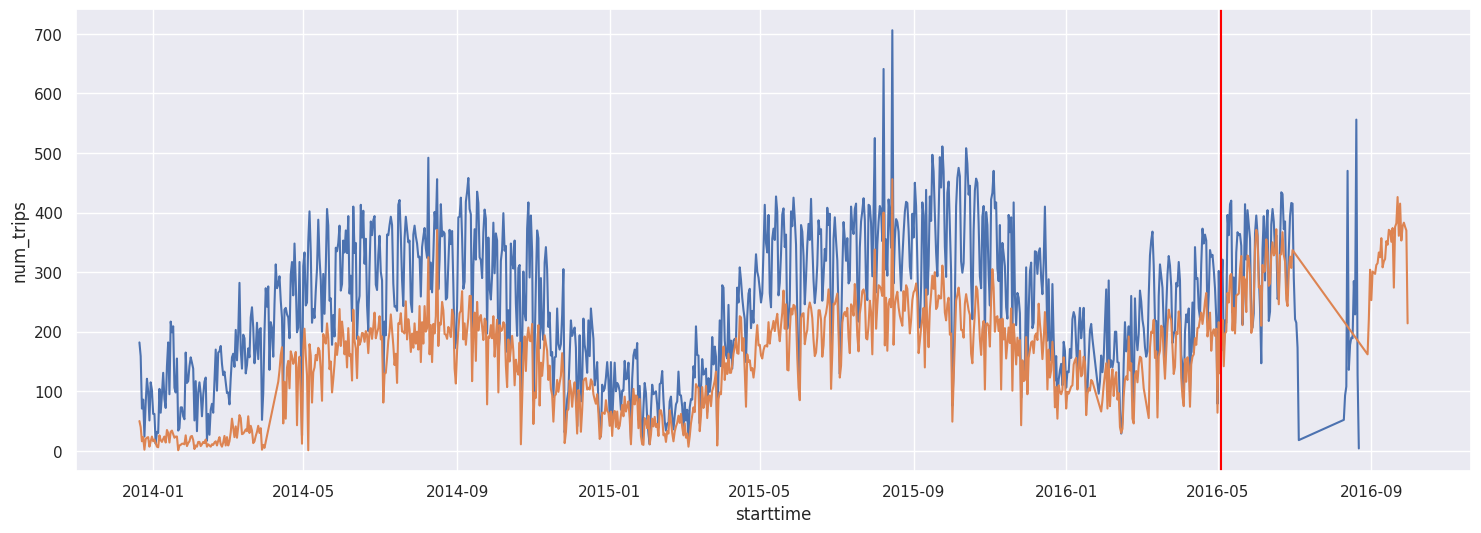

In [290]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(18,6)})
# sns.lineplot(x=rawSeries_nyc_cov_1.starttime, y=rawSeries_nyc_cov_1[TARGET_COLUMN])
# sns.lineplot(x=rawSeries_nyc_cov_2.starttime, y=rawSeries_nyc_cov_2[TARGET_COLUMN])
# sns.lineplot(x=rawSeries_nyc_cov_3.starttime, y=rawSeries_nyc_cov_3[TARGET_COLUMN])
sns.lineplot(x=rawSeries_nyc_cov_4.starttime, y=rawSeries_nyc_cov_4[TARGET_COLUMN])
sns.lineplot(x=rawSeries_nyc_target.index, y=rawSeries_nyc_target[INFLATED_TARGET])
plt.axvline(x= rawSeries_nyc_target.index[844], color='red');

## Create Combined Dataset
* Estimating the causal impact for a single time series ID
* Covariates will be the time series of similar IDs (bike stations)

In [291]:
rawSeries_nyc_cov_1.set_index(TIME_COLUMN, inplace=True, drop=False)#, inplace=True)
rawSeries_nyc_cov_2.set_index(TIME_COLUMN, inplace=True, drop=False)#, inplace=True)
rawSeries_nyc_cov_3.set_index(TIME_COLUMN, inplace=True, drop=False)#, inplace=True)
rawSeries_nyc_cov_4.set_index(TIME_COLUMN, inplace=True, drop=False)#, inplace=True)
# rawSeries_nyc_cov_4

In [145]:
# print(f"rawSeries_nyc_cov_1 start date: {rawSeries_nyc_cov_1.index.min()}")
# print(f"rawSeries_nyc_cov_2 start date: {rawSeries_nyc_cov_2.index.min()}")
# print(f"rawSeries_nyc_cov_3 start date: {rawSeries_nyc_cov_3.index.min()}")
# print(f"rawSeries_nyc_cov_4 start date: {rawSeries_nyc_cov_4.index.min()}")
# print(f"rawSeries_nyc_target start date: {rawSeries_nyc_target.index.min()}")

rawSeries_nyc_cov_1 start date: 2013-12-21
rawSeries_nyc_cov_2 start date: 2013-12-21
rawSeries_nyc_cov_3 start date: 2013-12-21
rawSeries_nyc_cov_4 start date: 2013-12-21
rawSeries_nyc_target start date: 2013-12-21


In [146]:
# print(f"rawSeries_nyc_cov_1 start date: {rawSeries_nyc_cov_1.index.max()}")
# print(f"rawSeries_nyc_cov_2 start date: {rawSeries_nyc_cov_2.index.max()}")
# print(f"rawSeries_nyc_cov_3 start date: {rawSeries_nyc_cov_3.index.max()}")
# print(f"rawSeries_nyc_cov_4 start date: {rawSeries_nyc_cov_4.index.max()}")
# print(f"rawSeries_nyc_target start date: {rawSeries_nyc_target.index.max()}")

rawSeries_nyc_cov_1 start date: 2016-09-30
rawSeries_nyc_cov_2 start date: 2016-09-27
rawSeries_nyc_cov_3 start date: 2016-09-30
rawSeries_nyc_cov_4 start date: 2016-08-22
rawSeries_nyc_target start date: 2016-09-30


In [308]:
rawSeries_nyc_target

,index,start_station_name,starttime,num_trips,num_trips_jt,splits,control_group,avg_tripduration,pct_subscriber,ratio_gender,capacity
starttime,,,,,,,,,,,
2013-12-21,5953,Lafayette St & Jersey St,2013-12-21,50,50,TRAIN,0,653.560000,0.960000,2.571429,60
2013-12-22,5954,Lafayette St & Jersey St,2013-12-22,40,40,TRAIN,0,530.000000,0.975000,2.636364,60
2013-12-23,5955,Lafayette St & Jersey St,2013-12-23,16,16,TRAIN,0,649.062500,0.875000,4.333333,60
2013-12-24,5956,Lafayette St & Jersey St,2013-12-24,23,23,TRAIN,0,818.000000,0.913043,2.285714,60
2013-12-25,5957,Lafayette St & Jersey St,2013-12-25,2,2,TRAIN,0,236.000000,1.000000,0.000000,60
...,...,...,...,...,...,...,...,...,...,...,...
2016-09-26,6883,Lafayette St & Jersey St,2016-09-26,232,377,TEST,1,735.474138,0.922414,2.362319,60
2016-09-27,6884,Lafayette St & Jersey St,2016-09-27,238,383,TEST,1,760.726891,0.924370,1.975000,60
2016-09-28,6885,Lafayette St & Jersey St,2016-09-28,231,376,TEST,1,637.714286,0.948052,2.553846,60


In [311]:
rawSeries_nyc_target_1 = rawSeries_nyc_target.rename(columns={'num_trips': 'num_trips_raw'})
rawSeries_nyc_target_1 = rawSeries_nyc_target_1.rename(columns={'num_trips_jt': 'target_num_trips'})

new_df = pd.merge(rawSeries_nyc_target_1['target_num_trips'],rawSeries_nyc_cov_1['num_trips'], how='left',left_index=True, right_index=True, suffixes=('_1', '_1a'))
new_df = new_df.rename(columns={'num_trips': 'x1_trips'})

new_df = pd.merge(new_df,rawSeries_nyc_cov_2['num_trips'], how='left',left_index=True, right_index=True) #, suffixes=('_2', '_2a'))
new_df = new_df.rename(columns={'num_trips': 'x2_trips'})

new_df = pd.merge(new_df,rawSeries_nyc_cov_3['num_trips'], how='left',left_index=True, right_index=True) #, suffixes=('_3', '_3a'))
new_df = new_df.rename(columns={'num_trips': 'x3_trips'})

new_df = pd.merge(new_df,rawSeries_nyc_cov_4['num_trips'], how='left',left_index=True, right_index=True) #, suffixes=('_4', '_4a'))
new_df = new_df.rename(columns={'num_trips': 'x4_trips'})

# Converting the index as date
new_df.index = pd.to_datetime(new_df.index)

new_df = new_df.astype({"target_num_trips":'float', "x1_trips":'float', "x2_trips":'float', "x3_trips":'float', "x4_trips":'float'})
new_df = new_df.fillna(0.0)

new_df

,target_num_trips,x1_trips,x2_trips,x3_trips,x4_trips
starttime,,,,,
2013-12-21,50.0,11.0,19.0,23.0,182.0
2013-12-22,40.0,15.0,13.0,20.0,159.0
2013-12-23,16.0,3.0,6.0,5.0,71.0
2013-12-24,23.0,4.0,9.0,12.0,86.0
2013-12-25,2.0,2.0,7.0,6.0,24.0
...,...,...,...,...,...
2016-09-26,377.0,58.0,41.0,56.0,0.0
2016-09-27,383.0,33.0,3.0,51.0,0.0
2016-09-28,376.0,48.0,0.0,53.0,0.0


In [312]:
new_df.dtypes

target_num_trips    float64
x1_trips            float64
x2_trips            float64
x3_trips            float64
x4_trips            float64
dtype: object

### Save BigQuery Table for later

In [153]:
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.prepped_subset` AS (
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    WHERE start_station_name LIKE '{TARGET_NYC_STATION}'
    OR start_station_name LIKE '{NYC_STATION_COV_1}'
    OR start_station_name LIKE '{NYC_STATION_COV_2}'
    OR start_station_name LIKE '{NYC_STATION_COV_3}'
    OR start_station_name LIKE '{NYC_STATION_COV_4}'
);
"""
print(query)


CREATE OR REPLACE TABLE `hybrid-vertex.causal_v1.prepped_subset` AS (
    SELECT *
    FROM `hybrid-vertex.causal_v1.causal_impact_v1_prepped`
    WHERE start_station_name LIKE 'Lafayette St & Jersey St'
    OR start_station_name LIKE 'Lafayette Ave & St James Pl'
    OR start_station_name LIKE 'Cumberland St & Lafayette Ave'
    OR start_station_name LIKE 'Lafayette Ave & Fort Greene Pl'
    OR start_station_name LIKE 'Lafayette St & E 8 St'
);



In [154]:
job = bq_client.query(query)
job.result()
print(job.state, (job.ended-job.started).total_seconds())

DONE 1.406


In [155]:
query = f"""
    SELECT * 
    FROM `{BQ_PROJECT}.{BQ_DATASET}.prepped_subset`
    ORDER BY {TIME_COLUMN} ASC;
"""
subset_df = bq_client.query(query).to_dataframe()
# subset_df

,start_station_name,starttime,num_trips,avg_tripduration,pct_subscriber,ratio_gender,capacity,num_trips_jt,splits,control_group
0,Lafayette St & E 8 St,2013-12-21,182,657.054945,0.901099,2.309091,91,182,TRAIN,0
1,Lafayette St & Jersey St,2013-12-21,50,653.560000,0.960000,2.571429,60,50,TRAIN,0
2,Lafayette Ave & St James Pl,2013-12-21,11,814.727273,0.909091,0.833333,39,11,TRAIN,0
3,Cumberland St & Lafayette Ave,2013-12-21,19,608.684211,0.947368,1.714286,27,19,TRAIN,0
4,Lafayette Ave & Fort Greene Pl,2013-12-21,23,639.173913,0.956522,1.090909,0,23,TRAIN,0
...,...,...,...,...,...,...,...,...,...,...
4878,Lafayette Ave & St James Pl,2016-09-29,57,612.491228,0.964912,3.750000,39,202,TEST,1
4879,Lafayette Ave & Fort Greene Pl,2016-09-29,49,794.204082,0.959184,1.722222,0,194,TEST,1
4880,Lafayette St & Jersey St,2016-09-30,69,518.594203,1.000000,3.058824,60,214,TEST,1
4881,Lafayette Ave & St James Pl,2016-09-30,16,744.562500,1.000000,7.000000,39,161,TEST,1


# Causal Impact

## Step 1 - set pre and post intervention

The python `CausalImpact` package requires the pre and the post periods inputs in a list format. The first element in the list is the starting index and the last element in the list is the ending index.

In [295]:
# INTERVENTION_DATE
# TREATMENT_DATE_obj = datetime.strptime(TREATMENT_DATE, '%Y-%m-%d').date()

# Set pre-period
pre_period = [str(new_df.index.min())[:10], str(TREATMENT_DATE_obj- timedelta(days=1))]

# Set post-period
post_period = [str(TREATMENT_DATE_obj), str(new_df.index.max())[:10]]

# Print out the values
print(f'The pre-period is {pre_period}')
print(f'The post-period is {post_period}')

The pre-period is ['2013-12-21', '2016-05-03']
The post-period is ['2016-05-04', '2016-09-30']


## Step 2 - calculate raw differences

**naive approach**
* pre-treatment daily average is ~144 
* post-treatment daily average is ~300, 
* raw difference between the pre and the post treatment is 155

In [296]:
index_int = new_df.index.get_loc(TREATMENT_DATE)

# Calculate the pre-daily average
pre_daily_avg = new_df['target_num_trips'][:index_int].mean()

# Calculate the post-daily average
post_daily_avg = new_df['target_num_trips'][index_int:].mean()

# Print out the results
print(f'The pre-treatment daily average is {pre_daily_avg}.')
print(f'The post-treatment daily average is {post_daily_avg}.')
print(f'The raw difference between the pre and the post treatment is {post_daily_avg - pre_daily_avg}.')

The pre-treatment daily average is 144.41469194312796.
The post-treatment daily average is 300.38461538461536.
The raw difference between the pre and the post treatment is 155.9699234414874.


## Step 3 - Causal Impact Analysis on Time Series

The causality analysis has two assumptions:
* Assumption 1: There are one or more control time series that are highly correlated with the response variable, but not impacted by the intervention. Violation of this assumption can result in wrong conclusions about the existence, the direction, or the magnitude of the treatment effect.
* Assumption 2: The correlation between the control and the response time series is the same for pre and post intervention.

The python `CausalImpact` package has a function called `CausalImpact` that implements a Bayesian Structural Time Series Model (BSTS) on the backend. It has three required inputs:
* `data` takes the python dataframe name.
* `pre_period` takes the starting and the ending index values for the pre-intervention period.
* `post_period` takes the starting and the ending index values for the post-intervention period.

After saving the output object in a variable called `impact`, we can run `impact.plot()` to visualize the results.

In [313]:
# Causal impact model
impact = CausalImpact(data=new_df, pre_period=pre_period, post_period=post_period)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/optimizer.py:23: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: standardize, nseasons. After release 0.14, this will raise.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date inde

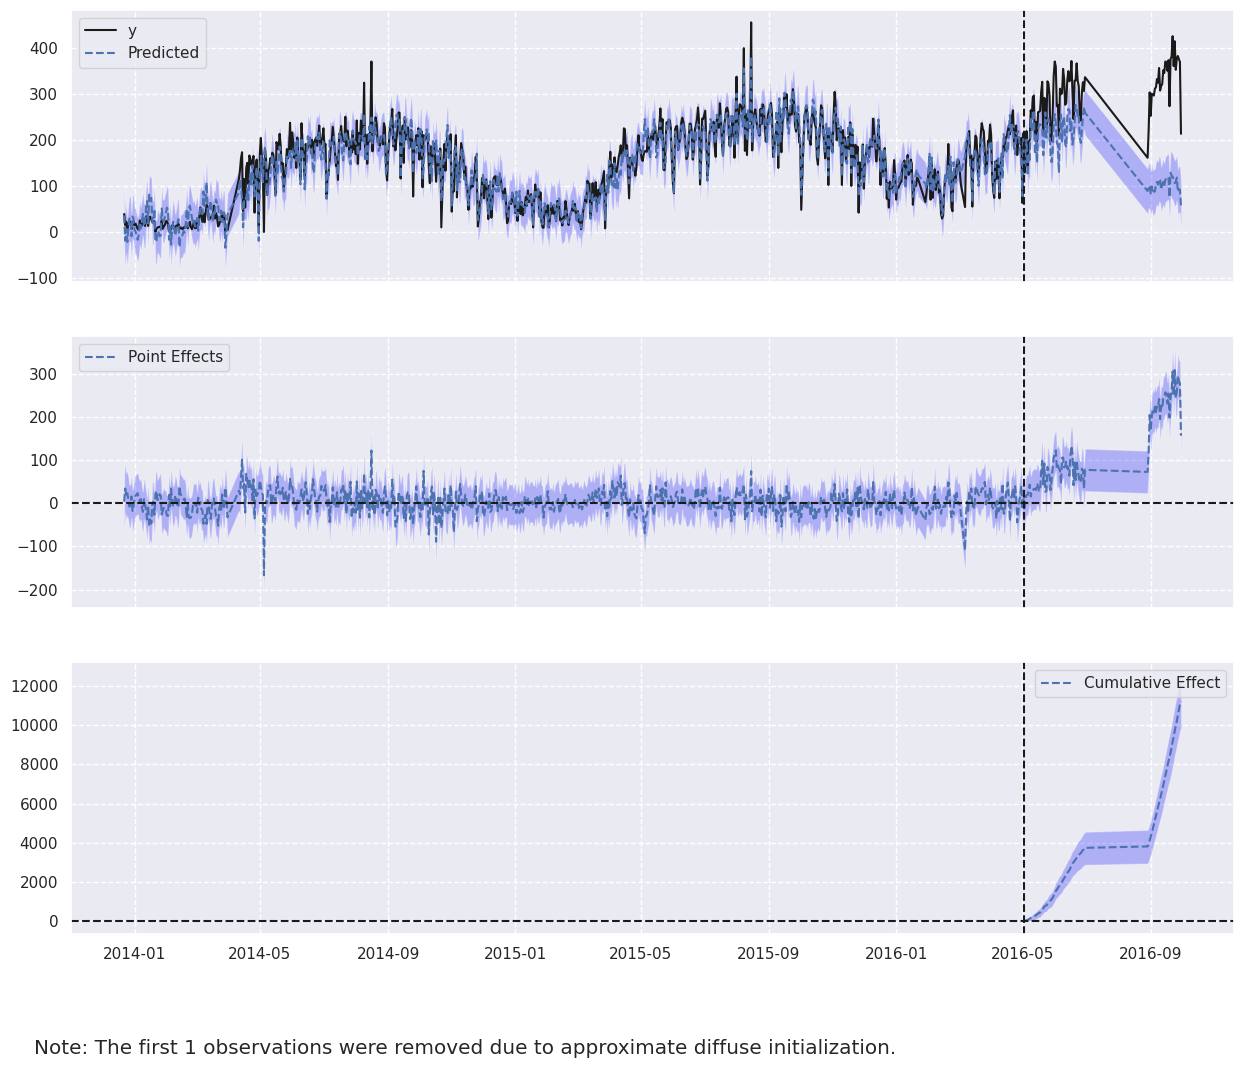

In [314]:
# Visualization
impact.plot()

The visualization consists of three charts:
* The first chart plots the predicted counterfactual values and the actual values for the post-period.
* The second chart plots the point effects, which are the differences between the actual and predicted values. We can see that the pre-period point effects values are all around 0, and the post-period point effects values are all around the true impact of `TODO-update`
* The third chart plots the cumulative effect, which is the cumulative sum of the point effects from the second chart.

# Causal Impact Summary

The summary from `impact.summary()` tells us that:
* The actual post-intervention average is 300.38, and the predicted post-intervention average is 176.95.
* The absolute causal effect is 123.44, 
* The relative causal effect is 69.76%.
* The posterior probability of a causal effect is 100%, showing that the model is very confident that the causal impact exists.

In [315]:
# Causal impact summary
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    300.38             27335.0
Prediction (s.d.)         176.95 (7.64)      16102.06 (695.46)
95% CI                    [162.01, 191.97]   [14742.95, 17469.1]

Absolute effect (s.d.)    123.44 (7.64)      11232.94 (695.46)
95% CI                    [108.42, 138.37]   [9865.9, 12592.05]

Relative effect (s.d.)    69.76% (4.32%)     69.76% (4.32%)
95% CI                    [61.27%, 78.2%]    [61.27%, 78.2%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


## Summary Report

In [317]:
# Causal impact report
print(impact.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 300.38. By contrast, in the absence of an
intervention, we would have expected an average response of 176.95.
The 95% interval of this counterfactual prediction is [162.01, 191.97].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 123.44 with a 95% interval of
[108.42, 138.37]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 27335.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 16102.06. The 95% interval of this prediction is [14742.95, 17469.1].


The above results are given in terms of absolute numbers. In relative
terms, the re